In [1]:
import numpy as np
import random

In [2]:
action_map = {
    "UP": 1,
    "DOWN": 2,
    "LEFT": 3,
    "RIGHT": 4
}

In [3]:
class Maze():
    
    def __init__(self):
        self.x = 5
        self.y = 3
        self.board = np.array([
            [0,0,0,0,0,0,0,0,3],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [1,1,1,1,1,1,1,1,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
        ])
        self.last_reward = None
        self.term = None
        
    def step(self, action, slip_prob=0.2):
        slips = np.random.choice([True, False], p=[slip_prob, 1-slip_prob])
        if slips:
            action = random.choice(list(action_map.keys()))
        rollback = (self.x, self.y)
        if action == "UP":
            self.x = np.clip(self.x-1, 0, 5)
        elif action == "DOWN":
            self.x = np.clip(self.x+1, 0, 5)
        elif action == "LEFT":
            self.y = np.clip(self.y-1, 0, 8)
        elif action == "RIGHT":
            self.y = np.clip(self.y+1, 0, 8)
        if self.board[self.x][self.y] == 1:
            self.x, self.y = rollback
            self.last_reward = 0
            self.term = False
        elif self.board[self.x][self.y] == 3:
            self.last_reward = 1
            self.term = True
        else:
            self.last_reward = 0
            self.term = False
    
    def reward(self):
        return (self.last_reward, self.term)
        
    def reset(self):
        self.x = 5
        self.y = 3
        self.last_reward = None
        self.term = None

In [57]:
class Agent():
    
    def __init__(self):
        self.t = 0
        self.watch = True
        self.env = Maze()
        
    def move(self, action):
        self.env.step(action)
        self.t+=1
        if self.t > 1000 and self.watch:
            self.env.board[3][0] = 0
            self.env.board[3][8] = 1
            self.watch = False
    
    def reward(self):
        return self.env.reward()
    
    def reset(self):
        self.env.reset()
        
    def dyna(self, n=250):
        steps = 3000
        cumrew = 0
        plot_data = []
        epsilon = 0.1
        gamma = 0.95
        lr = 0.1
        q = {(x, y, a) : 0 for x in range(6) for y in range(9) for a in action_map.keys()}
        m = {(x, y, a) : np.nan for x in range(6) for y in range(9) for a in action_map.keys()}
        o = {(x, y) : [] for x in range(6) for y in range(9)}
        for step in range(steps):
            plot_data.append(cumrew)
            x = self.env.x
            y = self.env.y
            a = np.random.choice(
                [max(list(action_map.keys()), key = lambda a: q[(x, y, a)]), random.choice(list(action_map.keys()))], 
                p=[1-epsilon, epsilon]
            )
            self.move(a)
            r, term = self.reward()
            o[(x, y)].append(a)
            x_new = self.env.x
            y_new = self.env.y
            q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
            m[(x,y,a)] = (r, x_new, y_new)
            if term:
                cumrew+=1
                self.reset()
                continue
            for n in range(n):
                x, y = random.choice(list(key for key in o.keys() if len(o[key])>0))
                a = random.choice(o[(x, y)])
                r, x_new, y_new = m[(x, y, a)]
                q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
        return plot_data, q
        
    def stoch(self, n=250):
        
        steps = 3000
        cumrew = 0
        plot_data = []
        epsilon = 0.1
        gamma = 0.95
        lr = 0.1
        beta = 2
        
        q = {(x, y, a) : 0 for x in range(6) for y in range(9) for a in action_map.keys()}
        m = {(x, y, a) : {} for x in range(6) for y in range(9) for a in action_map.keys()}
        o = {(x, y) : [] for x in range(6) for y in range(9)}
        
        for step in range(1,steps+1):
            
            plot_data.append(cumrew)
            
            x = self.env.x
            y = self.env.y
            a = np.random.choice(
                [max(list(action_map.keys()), key = lambda a: q[(x, y, a)]), random.choice(list(action_map.keys()))], 
                p=[1-epsilon, epsilon]
            )
            
            self.move(a)
            x_new = self.env.x
            y_new = self.env.y
            
            r, term = self.reward()
            
            q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
            if (r, x_new, y_new) in m.keys():
                m[(x,y,a)][(r, x_new, y_new)]+=1
            else:
                m[(x,y,a)][(r, x_new, y_new)]=1
            o[(x, y)].append(a)
            
            if term:
                cumrew+=1
                self.reset()
                continue
                
            for n in range(n):
                
                x, y = random.choice(list(key for key in o.keys() if len(o[key])>0))
                a = random.choice(o[(x, y)])
                
                keys = [key for key in m[(x,y,a)].keys()]
                vals = [m[(x,y,a)][key] for key in keys]
                occurances = sum(vals)
                vals = [val/occurances for val in vals]
                
                
                choice = np.random.choice(list(range(len(keys))), p=vals)
                r, x_new, y_new = keys[choice]
                q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
                
        return plot_data, q
    
    def changing(self, n=250):
        
        steps = 3000
        cumrew = 0
        plot_data = []
        epsilon = 0.1
        gamma = 0.95
        lr = 0.1
        beta = 2
        
        q = {(x, y, a) : 0 for x in range(6) for y in range(9) for a in action_map.keys()}
        m = {(x, y, a) : {} for x in range(6) for y in range(9) for a in action_map.keys()}
        o = {(x, y) : [] for x in range(6) for y in range(9)}
        visited = []
        
        for step in range(1,steps+1):
            
            plot_data.append(cumrew)
            
            x = self.env.x
            y = self.env.y
            a = np.random.choice(
                [max(list(action_map.keys()), key = lambda a: q[(x, y, a)]), random.choice(list(action_map.keys()))], 
                p=[1-epsilon, epsilon]
            )
            
            self.move(a)
            x_new = self.env.x
            y_new = self.env.y
            
            r, term = self.reward()
            
            q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
            if (r, x_new, y_new) in m.keys():
                m[(x,y,a)][(r, x_new, y_new)]+=(1)
            else:
                m[(x,y,a)][(r, x_new, y_new)]=(1)
            o[(x, y)].append(a)
            
            visited.append([(x,y,a), (r,x_new,y_new)])
            
            if term:
                cumrew+=1
                self.reset()
                continue
                
            temp_m = m
            
            for n in range(n):
                
                x, y = random.choice(list(key for key in o.keys() if len(o[key])>0))
                a = random.choice(o[(x, y)])
                
                keys = [key for key in temp_m[(x,y,a)].keys()]
                vals = [temp_m[(x,y,a)][key] for key in keys]
                
                done = []

                for idx in range(min(len(visited), 500)):
                    k1, k2 = visited[-idx]
                    if (k1,k2) not in done:
                        temp_m[k1][k2]=m[k1][k2]+np.sqrt(idx)
                    done.append((k1, k2))
                    
                
                occurances = sum(vals)
                vals = [val/occurances for val in vals]
                
                
                choice = np.random.choice(list(range(len(keys))), p=vals)
                r, x_new, y_new = keys[choice]
                q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
                
        return plot_data, q


100%|██████████| 10/10 [02:02<00:00, 12.23s/it]


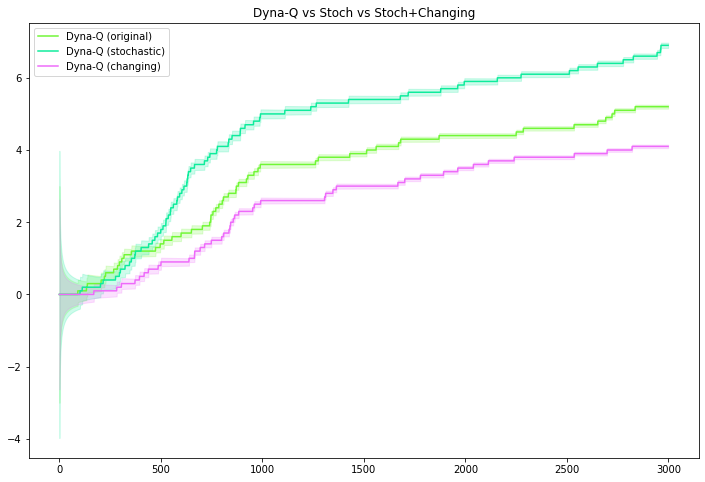

In [59]:
import matplotlib.pyplot as plt
from tqdm import tqdm


plt.figure(figsize=(12,8))

trials = 10
dyna_data = []
stoch_data = []
change_data = []

for trial in tqdm(range(trials)):
    agent = Agent()
    agent.reset()
    temp, _ = agent.dyna()
    dyna_data.append(temp)
    
    agent = Agent()
    agent.reset()
    temp, _ = agent.stoch()
    stoch_data.append(temp)
    
    agent = Agent()
    agent.reset()
    temp, _ = agent.changing()
    change_data.append(temp)

c = np.random.rand(3,)
plt.plot(np.mean(np.array(dyna_data), axis=0), label="Dyna-Q (original)", c=c)
rew_err = 1.96 * (np.std(np.mean(np.array(dyna_data), axis=0)) / np.sqrt(range(1,3001)))
plt.fill_between(range(3000), np.mean(np.array(dyna_data), axis=0) - rew_err, np.mean(np.array(dyna_data), axis=0) + rew_err, alpha=0.2, color=c)

c = np.random.rand(3,)
plt.plot(np.mean(np.array(stoch_data), axis=0), label="Dyna-Q (stochastic)", c=c)
rew_err = 1.96 * (np.std(np.mean(np.array(stoch_data), axis=0)) / np.sqrt(range(1,3001)))
plt.fill_between(range(3000), np.mean(np.array(stoch_data), axis=0) - rew_err, np.mean(np.array(stoch_data), axis=0) + rew_err, alpha=0.2, color=c)

c = np.random.rand(3,)
plt.plot(np.mean(np.array(change_data), axis=0), label="Dyna-Q (changing)", c=c)
rew_err = 1.96 * (np.std(np.mean(np.array(change_data), axis=0)) / np.sqrt(range(1,3001)))
plt.fill_between(range(3000), np.mean(np.array(change_data), axis=0) - rew_err, np.mean(np.array(change_data), axis=0) + rew_err, alpha=0.2, color=c)


plt.title("Dyna-Q vs Stoch vs Stoch+Changing")
plt.legend()